## Setup

In [13]:
import numpy as np
import pandas as pd
from itertools import combinations
import multiprocessing
import pickle
import statistics

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')

from utils import flatten

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'

## Functions

In [2]:
def increaseIncDF_binSize(df,binSize):
    """This collapses consective bins in an incidence DF
    to reduce dimensions. This also means that some multiway
    interactions are now collapsed and those edges will be
    pruned"""
    result = []
    names = []
    for i in range(0,len(df) - binSize + 1,binSize):
        summed_value = df.loc[i:i+binSize-1,:].sum()
        summed_value[summed_value > 0] = 1
        names.append(f"Bin{i}:{i+binSize-1}")
        result.append(summed_value)
    result_df = pd.DataFrame(result,index = names)
    result_df = result_df.loc[:,result_df.sum() >= 2]
    return(result_df)

def dfToDict(df,result_dict):
    """Takes in an incidence DF and converts to 
    a dictionary of hyperedges"""
    for col in df.columns:
        twoWayRatio = float(col.split("_")[1])
        indices = df.index[df[col] == 1].tolist()
        key = '_'.join(indices)

        tmpList = result_dict.get(key, [])
        if tmpList:
            tmpList[0] += 1
            tmpList[1].append(twoWayRatio)
        else:
            tmpList = [1,[twoWayRatio]]
        result_dict[key] = tmpList
    return [result_dict]

class IncDFCreator:
    """Replacing this function: makeIncDF_fromChainDists"""
    def __init__(self, numProcesses, prim_cutoff, sec_cutoff, offDiagLim):
        self.numProcesses = numProcesses
        self.prim_cutoff = prim_cutoff
        self.sec_cutoff = sec_cutoff
        self.offDiagLim = offDiagLim

    def preprocessMat(self, chainMat):
        """Get upper triangular matrix and number of rows"""
        nrow = chainMat.shape[0]
        chainMat_triu = np.triu(chainMat, k=1)
        return chainMat_triu, nrow
    
    def assessMultiway(self, slice):
        """How many 2-way contacts fall below secondary cutoff"""
        total = np.count_nonzero(slice)
        passThresh = np.count_nonzero(slice[slice < self.sec_cutoff])
        ratio = passThresh / total
        return(ratio)
        
    def perRow(self, args):
        """Per row of upper tri matrix, get potential list of
        neighbors that fulfill distance criteria. Take iterative
        n choose k subsets of the matrix if the elements fall below 
        primary cutoff. If all elements fall 
        below the secondary distance cutoff needed to make it interact, then
        report that as a hyperedge"""
        chainMat_triu, row_ix = args
        columns_to_add = []
        ratioVec = []
        self.nrow = chainMat_triu.shape[0]
        vec = chainMat_triu[row_ix, row_ix + self.offDiagLim:]
        #condition1 = (0 < vec)
        condition2 = (vec < self.prim_cutoff)
        possNeighbors = [row_ix + self.offDiagLim + index for index in np.where(condition2)[0]]
        possNeighbors.insert(0, row_ix)
        if possNeighbors:
            for ix in range(2, len(possNeighbors)):
                for comb in combinations(possNeighbors, ix):
                    d = chainMat_triu[np.ix_(comb, comb)]
                    ratioUnderThresh = self.assessMultiway(d)
                    if ratioUnderThresh >= 0.5:
                        new_column = np.zeros(self.nrow)
                        new_column[list(comb)] = 1
                        columns_to_add.append(new_column)
                        ratioVec.append(ratioUnderThresh)
        if columns_to_add:
            return [columns_to_add,ratioVec]
        else:
            return None

    def mp(self, chainMat_triu, nrow):
        """Define multiprocessing pool"""
        pool = multiprocessing.Pool(self.numProcesses)
        argument_pairs = [(chainMat_triu, row_ix) for row_ix in range(nrow)]
        results = pool.map(self.perRow, argument_pairs)
        return results

    def makeIncDF_fromChainDists_mp(self, chainMat):
        """Run the dist matrix --> incidence DF in a parallelized
        fashion"""
        chainMat_triu, nrow = self.preprocessMat(chainMat)
        results = self.mp(chainMat_triu, nrow)
        filtered_results = [arr[0] for arr in results if arr is not None]
        ratioVec = flatten([vec[1] for vec in results if vec is not None])
        df = pd.DataFrame(np.concatenate(filtered_results)).T
        return [df,ratioVec]

    def makeIncDF_fromChainDists_single(self, chainMat):
        """Run the dist matrix --> incidence DF in a single-threaded
        fashion"""
        chainMat_triu, nrow = self.preprocessMat(chainMat)
        res = []
        rV = []
        for i in range(nrow):
            args = (chainMat_triu, i)
            row_result = self.perRow(args)
            if row_result is not None:
                res.append(row_result[0])
                rV.append(row_result[1])
        filtered_results = [arr for arr in res if arr is not None]
        df = pd.DataFrame(np.concatenate(filtered_results)).T
        ratioVec = flatten(rV)
        return [df, ratioVec]

## Process chains function optimization

In [3]:
numProcesses = 4
prim_cutoff = 500
sec_cutoff = 550
offDiagLim = 3

creator = IncDFCreator(numProcesses, prim_cutoff, sec_cutoff, offDiagLim)

In [4]:
exMat = np.loadtxt(f'{dataDir}chains_500_10000_1500_1681171613/chain_dist_5292.txt')
# exChain = creator.makeIncDF_fromChainDists_mp(exMat)

In [5]:
A = creator.makeIncDF_fromChainDists_mp(exMat)
df = A[0]
ratios = A[1]


In [130]:
seventy = [index for index, value in enumerate(ratios) if value > 0.7]
len(seventy)

15672

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,66357,66358,66359,66360,66361,66362,66363,66364,66365,66366
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
df.index = ["Bin"+str(i) for i in range(500)]

In [168]:
inc_dict = {}
inc_dict = dfToDict(df,inc_dict)

In [7]:
bInc_by5 = increaseIncDF_binSize(df,5)

In [9]:
newCols = [str(bInc_by5.columns[i])+"_"+str(round(ratios[i],2)) 
           for i in range(bInc_by5.shape[1])]
bInc_by5.columns = newCols

In [10]:
bInc_dict = {}
bInc_dict = dfToDict(bInc_by5,bInc_dict)[0]

In [22]:
outDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.processChainsOutput_10k_500_sample1/'
file_path = f'{outDir}binConcatInc_3_500_550_1.pkl'

import pickle
with open(file_path,'wb') as pklFile:
    pickle.dump(bInc_dict,pklFile)

In [170]:
roi = 'Bin0:4_Bin5:9_Bin10:14_Bin30:34_Bin370:374'
ids = roi.split("_")

### this is convoluted but it works
sevenWay1 = np.where(bInc_by5.sum() == 5)[0].tolist()
print(len(sevenWay1))
actualColname = [bInc_by5.columns[s] for s in sevenWay1]
subset_binnedDF = bInc_by5[actualColname]
print(subset_binnedDF.shape)
subset_binnedDF2 = subset_binnedDF.loc[ids]
print(subset_binnedDF2.shape)
sevenWay2 = np.where(subset_binnedDF2.sum() == 5)[0].tolist()
print(len(sevenWay2))
actualColname2 = [subset_binnedDF2.columns[s] for s in sevenWay2]
subset_binnedDF2[actualColname2]

15206
(100, 15206)
(5, 15206)
26


,121,122,123,124,127,128,129,130,164,165,...,173,174,175,176,187,188,189,190,191,192
Bin0:4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin5:9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin10:14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin30:34,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin370:374,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [171]:
roi_iDF = df[actualColname2]
roi_iDF.loc[~(roi_iDF==0).all(axis=1)]

,121,122,123,124,127,128,129,130,164,165,...,173,174,175,176,187,188,189,190,191,192
Bin3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin10,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
Bin11,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
Bin33,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
Bin34,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Bin373,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Bin374,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [95]:
def makeHiC_fromInc(incDF):
    ## Convert incidence matrix to 2d hiC matrix
    nrow = incDF.shape[0]
    binIDs = list(incDF.index)
    if isinstance(binIDs[0],str) and ":" in binIDs[0]:
        sorted_binIDs = sorted(binIDs, key=sort_key)
    else:
        sorted_binIDs = binIDs.sort()
    df = pd.DataFrame(np.zeros(shape = (nrow,nrow)), index=sorted_binIDs, 
                      columns=sorted_binIDs)
    for read in incDF.columns:
        if isinstance(read,str) and ":" in read:
            support = int(read.split(":")[1])
        else:
            support = 1
        arr = incDF[read][incDF[read] == 1].index
        for a in arr:
            df.loc[a][a] += support
        combs = list(combinations(arr,2))
        for c in combs:
            df.loc[c[0]][c[1]] += support
            df.loc[c[1]][c[0]] += support
    return(df)

In [24]:
hic_mat = makeHiC_fromInc(df)

In [105]:
def multiresolutionProjMat(df, ratios, report):
    """Given an incidence DF and information about how many (ratio)
    2-way interactions of a multiway interactions are present in the data,
    calculate projection matrices at each resolution"""
    projMat_dict = {}
    for cutoff in [0.9,1]: #0.5,0.75,
        print(f"Making projection matrix for 2-way cutoff = {cutoff}")
        subset = [index for index, value in enumerate(ratios) if value >= cutoff]
        report.append(len(subset))
        subset_df = df.iloc[:,subset]
        hic_subset = makeHiC_fromInc(subset_df)
        projMat_dict[cutoff] = hic_subset
    return [projMat_dict,report]

In [106]:
report = []
pm_dict = multiresolutionProjMat(df,ratios,report)

Making projection matrix for 2-way cutoff = 0.9
Making projection matrix for 2-way cutoff = 1


(500, 500)


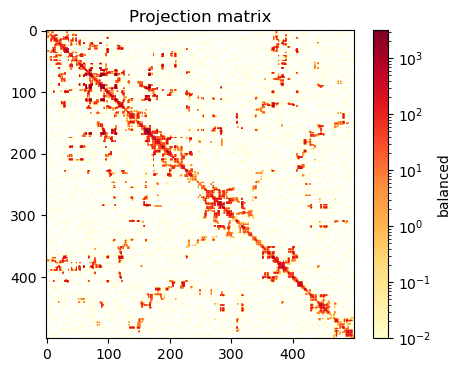

In [28]:
print(hic_mat.shape)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(hic_mat, cmap="YlOrRd",norm = LogNorm(vmax=10**3.5, vmin = 0.01)) #
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Projection matrix")
plt.show()

In [142]:
fileName = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.processChainsOutput_10k_500_sample1/projMats_3_500_550_2.pkl'
with open(fileName,'rb') as f:
    pm_dict = pickle.load(f)

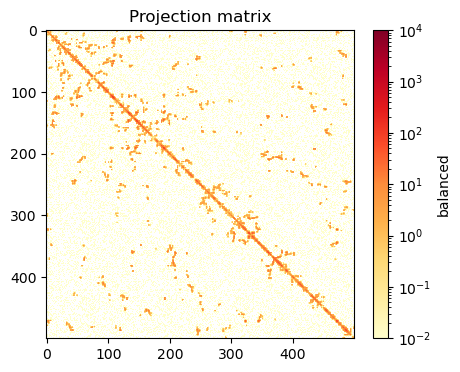

In [148]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(pm_dict[1], cmap="YlOrRd",norm = LogNorm(vmax=10**4, vmin = 0.01)) #
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Projection matrix")
plt.show()

## Comparing cutoffs and ratios to select best + fastest one for running

In [149]:
fileNames = ['binConcatInc_3_500_550_3.pkl','binConcatInc_1_500_550_3.pkl',
             'binConcatInc_3_500_550_4.pkl','binConcatInc_3_500_600_4.pkl','binConcatInc_3_500_650_4.pkl',
            'binConcatInc_3_500_550_6.pkl','binConcatInc_3_500_750_6.pkl',
            'binConcatInc_3_500_750_5.pkl','binConcatInc_3_550_750_5.pkl',
            'binConcatInc_1_500_750_5.pkl']

In [150]:
import os.path
outDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.processChainsOutput_10k_500_sample1/'

allDicts = {}
for file in fileNames:
    n = file.split("_")
    iter = n[4].split(".")[0]
    name = "_".join([n[2],n[3],n[1],"id",iter])
    file_path = f'{outDir}{file}'
    with open(file_path,'rb') as f:
        bIncDict = pickle.load(f)
        allDicts[name] = bIncDict


In [151]:
allDicts.keys()

dict_keys(['500_550_3_id_3', '500_550_1_id_3', '500_550_3_id_4', '500_600_3_id_4', '500_650_3_id_4', '500_550_3_id_6', '500_750_3_id_6', '500_750_3_id_5', '550_750_3_id_5', '500_750_1_id_5'])

#### 500_550. Off diagonal distance 1 versus 3

In [75]:
k3 = allDicts['500_550_3_id_3'].keys()
cards_k3 = [len(key.split("_")) for key in k3]
k1 = allDicts['500_550_1_id_3'].keys()
cards_k1 = [len(key.split("_")) for key in k1]

In [73]:
print(len(k1))
print(len(k3))
len(set(k3).intersection(k1))

3699
2977


2977

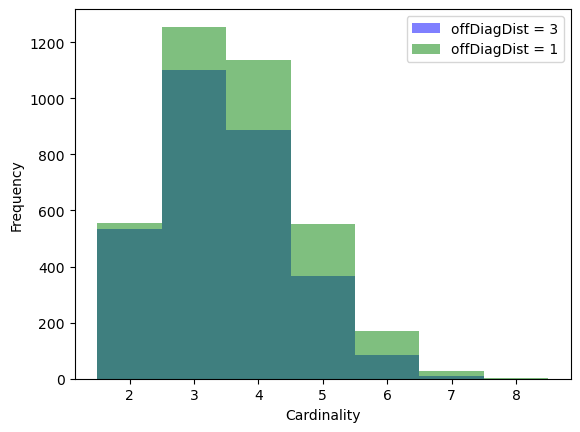

In [86]:
import matplotlib.pyplot as plt
plt.hist(cards_k3,bins = np.arange(2, 8 + 1.5) - 0.5, 
         alpha = 0.5, color='blue', label='offDiagDist = 3')
plt.hist(cards_k1,bins = np.arange(2, 8 + 1.5) - 0.5, 
         alpha = 0.5, color='green', label='offDiagDist = 1')

# Set labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### Prim 500. Off diag = 3. Secondary dist = 550, 600, 650

In [88]:
k550 = allDicts['500_550_3_id_4'].keys()
cards_k550 = [len(key.split("_")) for key in k550]
k600 = allDicts['500_600_3_id_4'].keys()
cards_k600 = [len(key.split("_")) for key in k600]
k650 = allDicts['500_650_3_id_4'].keys()
cards_k650 = [len(key.split("_")) for key in k650]

In [92]:
print(len(k550))
print(len(k600))
print(len(k650))

print(len(set(k650).intersection(k600)))
print(len(set(k650).intersection(k550)))

3429
3609
3719
3609
3429


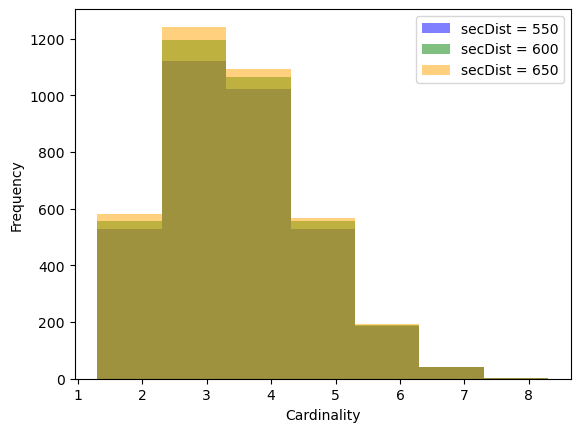

In [94]:
plt.hist(cards_k550,bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='blue', label='secDist = 550')
plt.hist(cards_k600,bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='green', label='secDist = 600')
plt.hist(cards_k650,bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='orange', label='secDist = 650')

# Set labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [97]:
print(allDicts['500_550_3_id_4']['Bin0:4_Bin350:354'])
print(allDicts['500_600_3_id_4']['Bin0:4_Bin350:354'])
print(allDicts['500_650_3_id_4']['Bin0:4_Bin350:354'])

[6, [1.0, 0.67, 1.0, 1.0, 1.0, 1.0]]
[7, [1.0, 1.0, 0.67, 1.0, 1.0, 1.0, 1.0]]
[7, [1.0, 1.0, 0.67, 1.0, 1.0, 1.0, 1.0]]


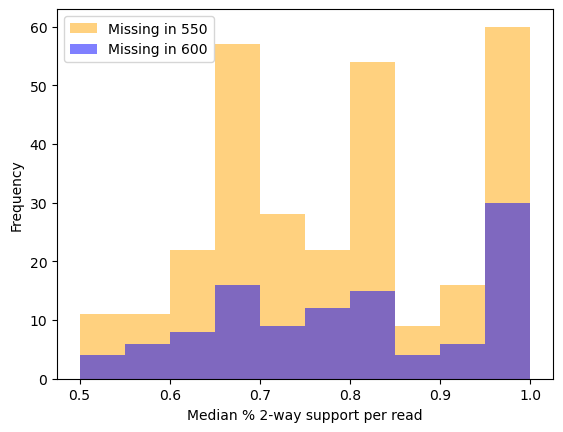

In [106]:
d650_550 = list(set(k650) - set(k550))
missingIn550 = [median(allDicts['500_650_3_id_4'][read][1]) for read in d650_550]

d650_600 = list(set(k650) - set(k600))
missingIn600 = [median(allDicts['500_650_3_id_4'][read][1]) for read in d650_600]

plt.hist(missingIn550,# bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='orange', label='Missing in 550')
plt.hist(missingIn600,# bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='blue', label='Missing in 600')

# Set labels and title
plt.xlabel('Median % 2-way support per read')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [109]:
median550 = [median(allDicts['500_550_3_id_4'][read][1]) for read in k550]
kosher550 = [index for index, value in enumerate(median550) if value == 1]

print(len(median550))
print(len(kosher550))

3429
394


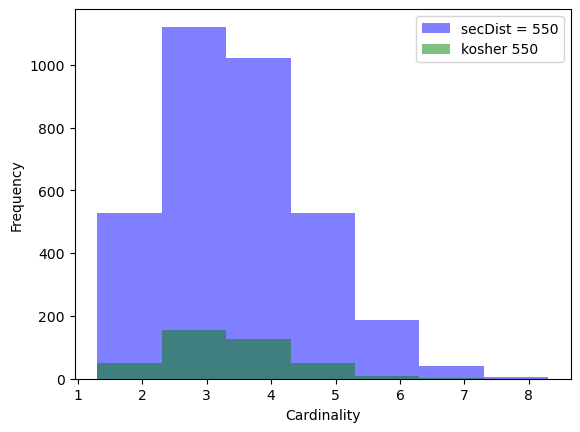

In [113]:
plt.hist(cards_k550,bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='blue', label='secDist = 550')
plt.hist([cards_k550[i] for i in kosher550],bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='green', label='kosher 550')

# Set labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### Prim 500. Off diag = 3. Secondary dist = 550 versus 750

In [114]:
l550 = allDicts['500_550_3_id_6'].keys()
cards_l550 = [len(key.split("_")) for key in l550]
l750 = allDicts['500_750_3_id_6'].keys()
cards_l750 = [len(key.split("_")) for key in l750]

In [115]:
print(len(l550))
print(len(l750))

print(len(set(l750).intersection(l550)))

3534
4071
3534


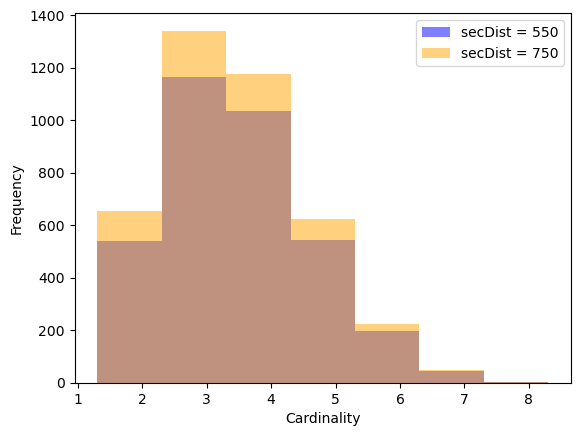

In [116]:
plt.hist(cards_l550,bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='blue', label='secDist = 550')
plt.hist(cards_l750,bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='orange', label='secDist = 750')

# Set labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [118]:
median750 = [median(allDicts['500_750_3_id_6'][read][1]) for read in l750]
kosher750 = [index for index, value in enumerate(median750) if value == 1]

print(len(median750))
print(len(kosher750))

4071
1869


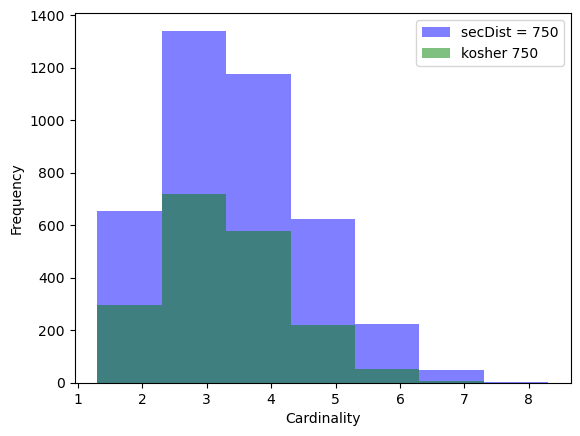

In [132]:
plt.hist(cards_l750,bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='blue', label='secDist = 750')
plt.hist([cards_l750[i] for i in kosher750],bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='green', label='kosher 750')

# Set labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

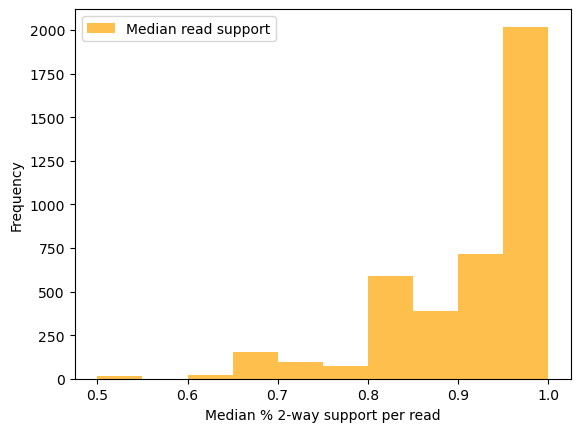

In [121]:
medianReadSupport = [median(allDicts['500_750_3_id_6'][read][1]) for read in l750]

plt.hist(medianReadSupport,# bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.7, color='orange', label='Median read support')

# Set labels and title
plt.xlabel('Median % 2-way support per read')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

### Prim cutoff 500 versus 550. Sec cutoff 750. Off diag dist 3

In [129]:
p500 = allDicts['500_750_3_id_5'].keys()
cards_p500 = [len(key.split("_")) for key in p500]
p550 = allDicts['550_750_3_id_5'].keys()
cards_p550 = [len(key.split("_")) for key in p550]

In [131]:
print(len(p500))
print(len(p550))

print(len(set(p500).intersection(p550)))

3183
7329
3183


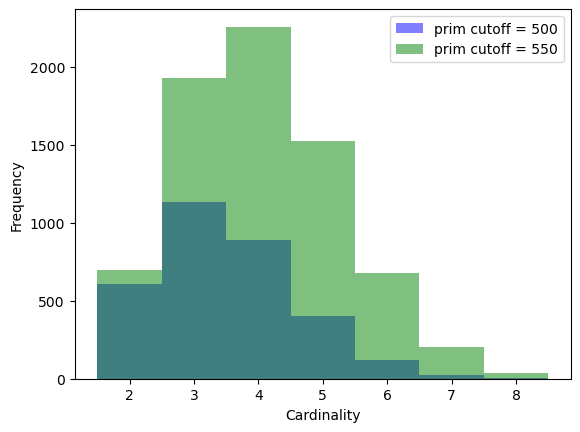

In [130]:
import matplotlib.pyplot as plt
plt.hist(cards_p500,bins = np.arange(2, 8 + 1.5) - 0.5, 
         alpha = 0.5, color='blue', label='prim cutoff = 500')
plt.hist(cards_p550,bins = np.arange(2, 8 + 1.5) - 0.5, 
         alpha = 0.5, color='green', label='prim cutoff = 550')

# Set labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

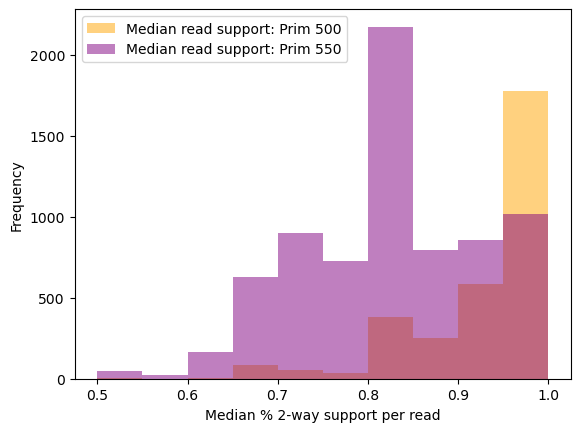

In [135]:
mRS_500 = [median(allDicts['500_750_3_id_5'][read][1]) for read in p500]
mRS_550 = [median(allDicts['550_750_3_id_5'][read][1]) for read in p550]

plt.hist(mRS_500,# bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='orange', label='Median read support: Prim 500')
plt.hist(mRS_550,# bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='purple', label='Median read support: Prim 550')

# Set labels and title
plt.xlabel('Median % 2-way support per read')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

### Prim 500 versus 550. Sec 750. Off diag 1 versus 3

In [154]:
n3_550 = allDicts['550_750_3_id_5'].keys()
cards_n3_550 = [len(key.split("_")) for key in n3_550]
n1 = allDicts['500_750_1_id_5'].keys()
cards_n1 = [len(key.split("_")) for key in n1]

In [155]:
print(len(n1))
print(len(n3_550))

print(len(set(n1).intersection(n3_550)))

3849
7329
3454


In [159]:
3454/3849

0.8973759418030657

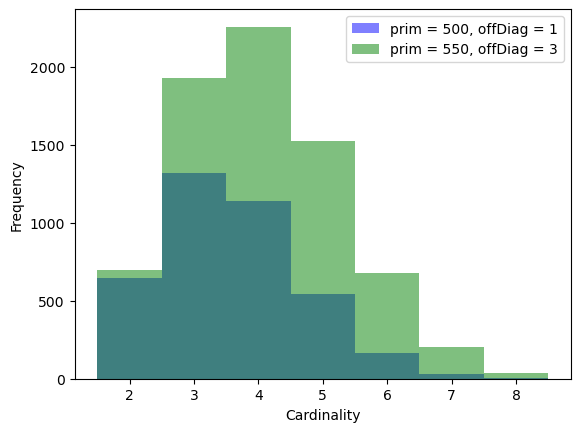

In [157]:
import matplotlib.pyplot as plt
plt.hist(cards_n1,bins = np.arange(2, 8 + 1.5) - 0.5, 
         alpha = 0.5, color='blue', label='prim = 500, offDiag = 1')
plt.hist(cards_n3_550,bins = np.arange(2, 8 + 1.5) - 0.5, 
         alpha = 0.5, color='green', label='prim = 550, offDiag = 3')

# Set labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

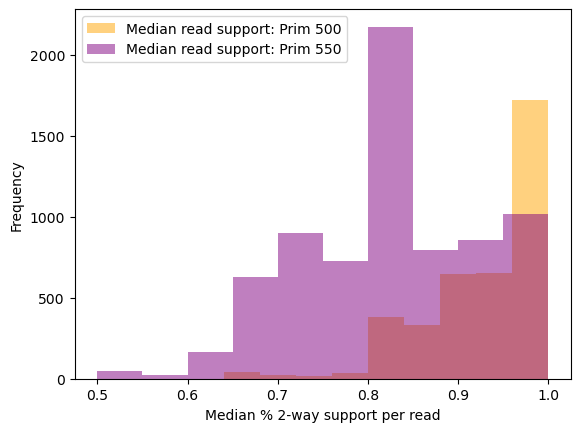

In [158]:
mRS_n1 = [median(allDicts['500_750_1_id_5'][read][1]) for read in n1]
mRS_n3_550 = [median(allDicts['550_750_3_id_5'][read][1]) for read in n3_550]

plt.hist(mRS_n1,# bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='orange', label='Median read support: Prim 500')
plt.hist(mRS_n3_550,# bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='purple', label='Median read support: Prim 550')

# Set labels and title
plt.xlabel('Median % 2-way support per read')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

## extending dicts: code optim

In [115]:
import os.path
outDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.processChainsOutput_10k_500_sample1/'

newDict = {}
for i in [1,2]:
    file_path = f'{outDir}binConcatInc_3_500_550_1.pkl'
    if os.path.isfile(file_path):
        with open(file_path,'rb') as f:
            bIncDict = pickle.load(f)


In [14]:
a1 = {'Bin0:4_Bin5:9': [4, [1.0, 1.0, 1.0, 0.67]],
 'Bin0:4_Bin370:374': [4, [1.0, 1.0, 1.0, 0.67]],
 'Bin0:4_Bin5:9_Bin370:374': [5, [1.0, 0.67, 1.0, 1.0, 0.5]],
 'Bin0:4_Bin10:14': [3, [1.0, 1.0, 0.67]],
 'Bin0:4_Bin30:34': [3, [1.0, 1.0, 1.0]],
 'Bin5:9_Bin10:14': [4, [1.0, 1.0, 0.67, 0.83]]}

a2 = {'Bin95:99_Bin185:189': [3, [0.67, 0.64, 0.5]],
 'Bin95:99_Bin200:204': [4, [0.5, 1.0, 0.6, 0.8]],
 'Bin0:4_Bin5:9_Bin370:374': [5, [1.0, 0.67, 1.0, 1.0, 0.5]],
 'Bin185:189_Bin205:209': [3, [1.0, 0.6, 0.57]],
 'Bin185:189_Bin210:214': [6, [0.7, 0.53, 0.61, 0.57, 1.0, 0.6]],
 'Bin190:194_Bin205:209': [5, [1.0, 0.6, 0.53, 0.67, 0.57]]}


In [15]:
resultDict = {}

def appendSingleBIncDict(chainDict,resultDict):
    """Takes in a binned inc dictionary which contains the
    read, number of times it occurred in a chain, and the
    % two-way support for that multiway read. It combines 
    each element, i.e., 3 elements per key to create a
    a bigger chunked dict."""
    for key, value in chainDict.items():
        tmpList = resultDict.get(key,[])
        if tmpList:
            tmpList[0] += value[0]
            tmpList[1] += 1
            tmpList[2].append(value[1])
        else:
            tmpList = [value[0],1,value[1]]
        resultDict[key] = tmpList
    return(resultDict)

for chainDict in [a1,a2]:
    resultDict = appendSingleBIncDict(chainDict,resultDict)

print(resultDict)

{'Bin0:4_Bin5:9': [4, 1, [1.0, 1.0, 1.0, 0.67]], 'Bin0:4_Bin370:374': [4, 1, [1.0, 1.0, 1.0, 0.67]], 'Bin0:4_Bin5:9_Bin370:374': [10, 2, [1.0, 0.67, 1.0, 1.0, 0.5, [1.0, 0.67, 1.0, 1.0, 0.5]]], 'Bin0:4_Bin10:14': [3, 1, [1.0, 1.0, 0.67]], 'Bin0:4_Bin30:34': [3, 1, [1.0, 1.0, 1.0]], 'Bin5:9_Bin10:14': [4, 1, [1.0, 1.0, 0.67, 0.83]], 'Bin95:99_Bin185:189': [3, 1, [0.67, 0.64, 0.5]], 'Bin95:99_Bin200:204': [4, 1, [0.5, 1.0, 0.6, 0.8]], 'Bin185:189_Bin205:209': [3, 1, [1.0, 0.6, 0.57]], 'Bin185:189_Bin210:214': [6, 1, [0.7, 0.53, 0.61, 0.57, 1.0, 0.6]], 'Bin190:194_Bin205:209': [5, 1, [1.0, 0.6, 0.53, 0.67, 0.57]]}


In [20]:
import os.path
import pickle

dictDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.makeCombinedHypergraphDicts/'

file_path = f'{dictDir}hyperEdges_3_500_550_final_chains.pkl'
if os.path.isfile(file_path):
    with open(file_path,'rb') as f:
        finalDict = pickle.load(f)

In [41]:
from statistics import median

hpKeys = finalDict.keys()
totalReadSupport = [v[0] for v in finalDict.values()]
totalChainSupport = [v[1] for v in finalDict.values()]
medianReadConfPerChain = [[median(rat) for rat in flatten(v[2])] for v in finalDict.values()]
readCards = [v[3] for v in finalDict.values()]

In [164]:
a = [1,2,3]
a.extend([4])
a

[1, 2, 3, 4]

In [24]:
from statistics import mean
from statistics import median

a = [1.0, 0.67, 0.67, 0.5, 0.52, 0.57]
print(mean(a))
print(median(a))

0.655
0.62


## Taking final chain dicts and running QC on that 

In [76]:
outDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.makeCombinedHypergraphDicts/sample2/'
#with open(f'{outDir}hyperEdges_3_550_750_final_chains_500.pkl','rb') as f:
with open(f'{outDir}hyperEdges_1_500_750_final_chains.pkl','rb') as f:
    finalChains = pickle.load(f)

In [77]:
from statistics import median
print(len(finalChains))
hpKeys = list(finalChains.keys())
readSupport = [v[0] for v in finalChains.values()]
chainSupport = [v[1] for v in finalChains.values()]
medOfMeds = [median(v[2]) for v in finalChains.values()]
readCards = [v[3] for v in finalChains.values()]

5371539


In [78]:
print(hpKeys[0:4])
finalChains['Bin0:4_Bin20:24']

i = 599231 #87, 285970
print(hpKeys[i],readSupport[i],chainSupport[i],medOfMeds[i],readCards[i])

['Bin0:4_Bin55:59', 'Bin0:4_Bin60:64', 'Bin0:4_Bin65:69', 'Bin0:4_Bin75:79']
Bin65:69_Bin240:244_Bin290:294 42 5 0.89 3


In [79]:
A = zip(readCards,chainSupport,readSupport,hpKeys)
a_df = pd.DataFrame(A)
a_df.columns = ["card","chainSupport","readSupport","key"]

In [80]:
def getGM_pairwise(k):
    binIDs = [int(i.split(":")[1]) for i in k.split("_")]
    combs = list(combinations(binIDs,2))
    distances = [(item[1]-item[0]) // 5 for item in combs]
    if 1 in distances:
        return None
    else:
        gm = round(statistics.mean(distances)) #statistics.geometric_mean
        return(gm)

In [81]:
a_df['GM_dist'] = [getGM_pairwise(key) for key in a_df['key']]

In [82]:
a_df.head()

,card,chainSupport,readSupport,key,GM_dist
0,2,3365,124321,Bin0:4_Bin55:59,11.0
1,2,3091,112112,Bin0:4_Bin60:64,12.0
2,2,2964,110882,Bin0:4_Bin65:69,13.0
3,2,2530,85266,Bin0:4_Bin75:79,15.0
4,2,2160,67455,Bin0:4_Bin90:94,18.0


In [83]:
a_df[(a_df['card']==3) & (a_df['chainSupport']>200) & 
     (a_df['GM_dist'] > 6)].sort_values(by=['chainSupport'], ascending=False)

,card,chainSupport,readSupport,key,GM_dist
59118,3,1361,56993,Bin10:14_Bin20:24_Bin60:64,7.0
43949,3,1356,64472,Bin5:9_Bin25:29_Bin55:59,7.0
16155,3,1344,63616,Bin5:9_Bin20:24_Bin55:59,7.0
52323,3,1338,58536,Bin260:264_Bin270:274_Bin310:314,7.0
1297,3,1332,50595,Bin15:19_Bin25:29_Bin65:69,7.0
...,...,...,...,...,...
83280,3,201,6577,Bin110:114_Bin130:134_Bin160:164,7.0
118881,3,201,5248,Bin60:64_Bin85:89_Bin170:174,15.0
46376,3,201,6913,Bin325:329_Bin390:394_Bin415:419,12.0
77922,3,201,7168,Bin430:434_Bin445:449_Bin485:489,7.0


In [59]:
i = 387499
print(hpKeys[i],readSupport[i],chainSupport[i],medOfMeds[i],readCards[i])

Bin5:9_Bin15:19_Bin25:29_Bin70:74 13868 225 0.9 4


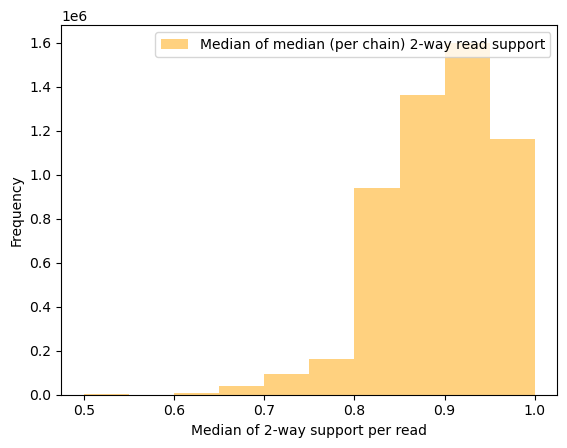

In [84]:
import matplotlib.pyplot as plt

plt.hist(medOfMeds,# bins = np.arange(2, 8 + 1.5) - 0.7, 
         alpha = 0.5, color='orange', label='Median of median (per chain) 2-way read support')

# Set labels and title
plt.xlabel('Median of 2-way support per read')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

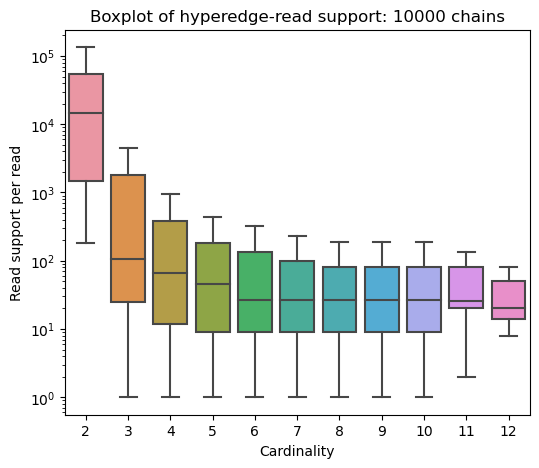

In [86]:
# Create a boxplot using seaborn
import seaborn as sns
numFiles = 10000

overallReadSupp_byCard = pd.DataFrame({'Cardinality':readCards, 'OverallReadSupport': readSupport})

plt.figure(figsize=(6, 5))
sns.boxplot(data=overallReadSupp_byCard, x='Cardinality', y='OverallReadSupport',showfliers=False)

#plt.xlim(0, 50)
plt.yscale("log")

# Add labels and title
plt.xlabel("Cardinality")
plt.ylabel("Read support per read")
plt.title(f"Boxplot of hyperedge-read support: {numFiles} chains")

# Show the plot
plt.show()

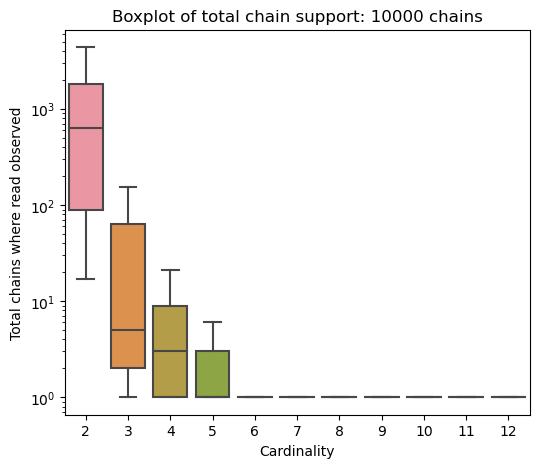

In [87]:
# Create a boxplot using seaborn
overallChainSupp_byCard = pd.DataFrame({'Cardinality':readCards, 'OverallChainSupport': chainSupport})

plt.figure(figsize=(6, 5))
sns.boxplot(data=overallChainSupp_byCard, x='Cardinality', y='OverallChainSupport',showfliers=False)

#plt.xlim(0, 50)
plt.yscale("log")

# Add labels and title
plt.xlabel("Cardinality")
plt.ylabel("Total chains where read observed")
plt.title(f"Boxplot of total chain support: {numFiles} chains")

# Show the plot
plt.show()

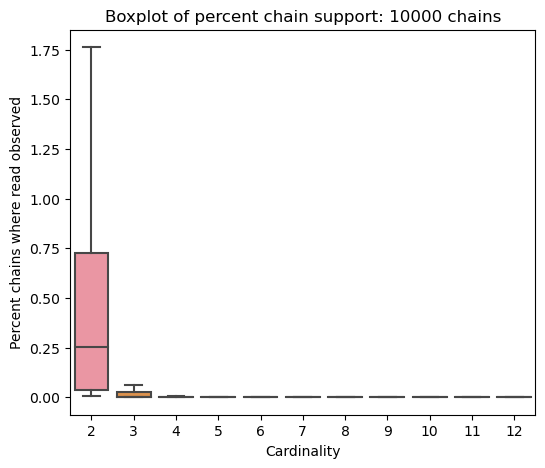

In [88]:
# Create a boxplot using seaborn
overallChainSupp_byCard = pd.DataFrame({'Cardinality':readCards, 
                                        'percChainSupport': [c/2500 for c in chainSupport]})

plt.figure(figsize=(6, 5))
sns.boxplot(data=overallChainSupp_byCard, x='Cardinality', y='percChainSupport',showfliers=False)

# #plt.xlim(0, 50)
# plt.yscale("log")

# Add labels and title
plt.xlabel("Cardinality")
plt.ylabel("Percent chains where read observed")
plt.title(f"Boxplot of percent chain support: {numFiles} chains")

# Show the plot
plt.show()

In [67]:
## Naively: read score versus chain support

from edgeWeightFormulations import finalBounded
from chains import dictToDF

# finalBoundedScores = [finalBounded(list(subset_incDF[c])) for c in subset_incDF.columns]

In [89]:
atLeastTwoChains = [i for i,x in enumerate(chainSupport) if x >=2]

In [90]:
dictWithKeysOfInterest = {hpKeys[i]:chainSupport[i] for i in atLeastTwoChains}

In [ ]:
### Left off here ---- 

In [70]:
finalDF = dictToDF(dictWithKeysOfInterest)

In [71]:
scores = [finalBounded(list(finalDF[c])) for c in finalDF.columns]

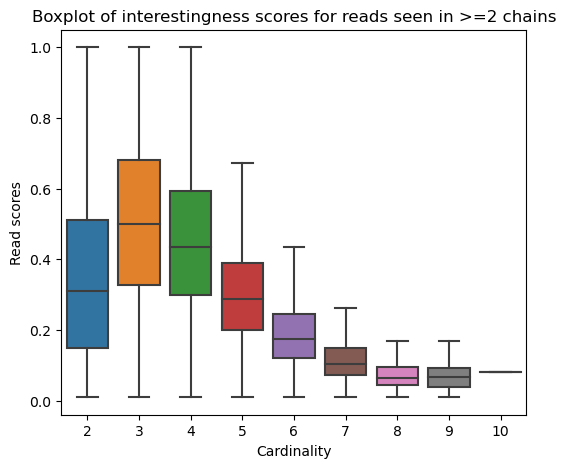

In [72]:
# Create a boxplot using seaborn
scoresByCard_multiChainReads = pd.DataFrame(
    {'Cardinality':[readCards[a] for a in atLeastTwoChains], 
     'readScores': scores})

plt.figure(figsize=(6, 5))
sns.boxplot(data=scoresByCard_multiChainReads, x='Cardinality', y='readScores',showfliers=False)

# #plt.xlim(0, 50)
# plt.yscale("log")

# Add labels and title
plt.xlabel("Cardinality")
plt.ylabel("Read scores")
plt.title(f"Boxplot of interestingness scores for reads seen in >=2 chains")

# Show the plot
plt.show()

In [70]:
card4 = [i for i,x in enumerate(readCards) if x == 4]
card4_chainSupport = [chainSupport[c4] for c4 in card4]
card4Keys = [hpKeys[c4] for c4 in card4]
card4_dict = {hpKeys[i]:chainSupport[i] for i in card4}
card4_DF = dictToDF(card4_dict)
scores_card4 = [card4_DF(list(finalDF[c])) for c in card4Keys]

KeyboardInterrupt: 

1211817

In [ ]:
## Make multiple incDFs ? Or somehow save the ratio in a vector
## Make binned DF first
## Then dict
## Then extend and combine